# 1. Cài đặt các thư viện cần thiết

In [1]:
!pip install pandas
!pip install sentence-transformers
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Đọc dữ liệu từ file CSV và hiển thị

In [3]:
import pandas as pd

# Đọc dữ liệu từ file CSV
file_path = "cleaned_amazon_reviews.csv"
df = pd.read_csv(file_path)

# Xem qua dữ liệu
print(df.head())

   STT                                           Đánh giá
0    1  Buying a used phone can be an anxiety filled e...
1    2  On my journey of ordering a refurbished iPhone...
2    3  I got the iPhone 12 Pro with Amazon’s “renewed...
3    4  This is the third refurbished item I’ve ordere...
4    5  I wanted to wait a couple months before writin...


# 3. Tiền xử lý dữ liệu

In [4]:
import re

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower()  # Chuyển thành chữ thường
    text = re.sub(r'[^\w\s]', '', text)  # Xóa dấu câu
    text = text.strip()  # Xóa khoảng trắng thừa
    return text

# Áp dụng hàm tiền xử lý
df['Đánh giá'] = df['Đánh giá'].apply(preprocess_text)


# 4. Tạo Embeddings với sentenceBERT

In [5]:
from sentence_transformers import SentenceTransformer

# Khởi tạo mô hình sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Tạo embeddings cho các đánh giá
embeddings = model.encode(df['Đánh giá'].tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 5. Phân Cụm Dữ Liệu

In [6]:
from sklearn.cluster import KMeans

# Số lượng cụm (clusters) bạn muốn
num_clusters = 5

# Khởi tạo và huấn luyện mô hình K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)

# Thêm nhãn cụm vào DataFrame
df['Cluster'] = kmeans.labels_

# Xem kết quả phân cụm
print(df.head())


   STT                                           Đánh giá  Cluster
0    1  buying a used phone can be an anxiety filled e...        1
1    2  on my journey of ordering a refurbished iphone...        1
2    3  i got the iphone 12 pro with amazons renewed  ...        1
3    4  this is the third refurbished item ive ordered...        1
4    5  i wanted to wait a couple months before writin...        3


# 6. Phân Tích Kết Quả

Cluster
3    51
1    25
2    15
0     5
4     4
Name: count, dtype: int64


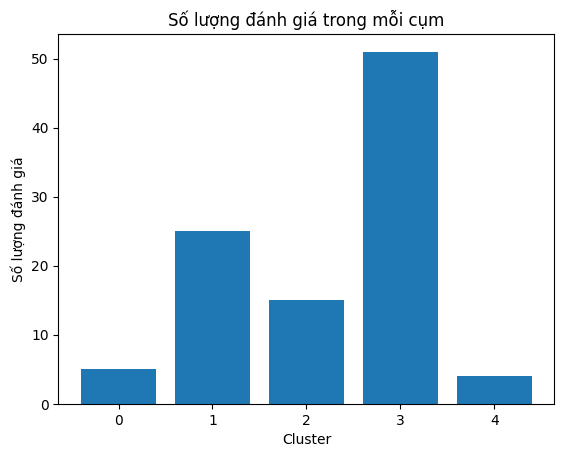

In [7]:
import matplotlib.pyplot as plt

# Phân tích số lượng đánh giá trong mỗi cụm
cluster_counts = df['Cluster'].value_counts()
print(cluster_counts)

# Vẽ biểu đồ số lượng đánh giá trong mỗi cụm
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Số lượng đánh giá')
plt.title('Số lượng đánh giá trong mỗi cụm')
plt.show()


# 7. Trực Quan Hóa Dữ Liệu

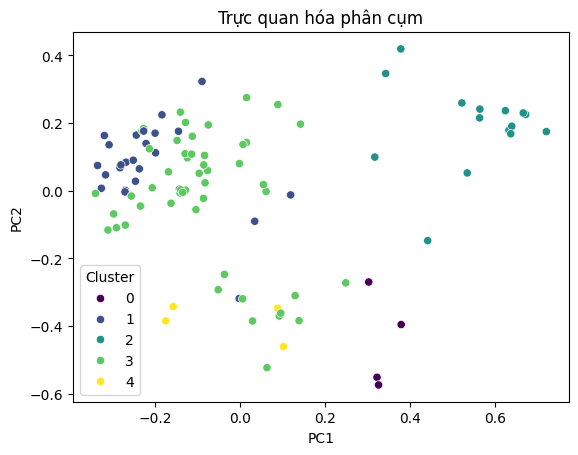

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns

# Giảm chiều dữ liệu xuống 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Tạo DataFrame cho t-SNE
tsne_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
tsne_df['Cluster'] = df['Cluster']

# Vẽ biểu đồ phân cụm
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=tsne_df, palette='viridis')
plt.title('Trực quan hóa phân cụm')
plt.show()


# 8. Cài đặt thư viện transformers và huggingface_hub

In [9]:
!pip install transformers torch huggingface_hub

In [10]:
import pandas as pd

# df là DataFrame chứa các đánh giá và nhãn cụm
# Gộp tất cả đánh giá của mỗi cụm thành một văn bản duy nhất
cluster_texts = df.groupby('Cluster')['Đánh giá'].apply(lambda x: ' '.join(x)).reset_index()
cluster_texts.columns = ['Cluster', 'Text']

# Kiểm tra kết quả
print(cluster_texts.head())


   Cluster                                               Text
0        0       good not bad good i used for work works fine
1        1  buying a used phone can be an anxiety filled e...
2        2  lo compré para mi mamá y el celular funciona m...
3        3  i wanted to wait a couple months before writin...
4        4  the first one i received was doa the second on...


In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

access_token = ""  # Thay bằng token của bạn
model_name = "meta-llama/Meta-Llama-3.1-8B"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=access_token)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_auth_token=access_token,
    torch_dtype=torch.bfloat16,
    device_map="auto",  # Quan trọng cho việc quản lý bộ nhớ với model lớn
    load_in_8bit=False,  # Đảm bảo không load ở 8-bit
    load_in_4bit=False  # Đảm bảo không load ở 4-bit
)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:810: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [12]:
# Kiểm tra pad_token_id
print(f"Pad token ID: {tokenizer.pad_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")

Pad token ID: None
EOS token ID: 128001


In [13]:
# Nếu pad_token_id không được thiết lập thì thiết lập nó
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [14]:
# Kiểm tra pad_token_id
print(f"Pad token ID: {tokenizer.pad_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")

Pad token ID: 128001
EOS token ID: 128001


In [15]:
from tqdm import tqdm

# Hàm tóm tắt văn bản
def generate_summary(text, max_new_tokens=150):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Lấy attention mask và pad token id
    attention_mask = inputs.get('attention_mask', None)
    pad_token_id = tokenizer.pad_token_id

    # Generate summary
    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=attention_mask,  # Thêm attention_mask
            pad_token_id=pad_token_id,      # Đặt pad_token_id
            max_new_tokens=max_new_tokens,   # Sử dụng max_new_tokens để điều chỉnh độ dài đầu ra
            num_beams=4,
            early_stopping=True
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Áp dụng mô hình để tạo ra tóm tắt cho mỗi cụm với thanh tiến trình
tqdm.pandas(desc="Đang tóm tắt các cụm...")
cluster_texts['Summary'] = cluster_texts['Text'].progress_apply(generate_summary)

# Xem kết quả
print(cluster_texts.head())


Đang tóm tắt các cụm...:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2134: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
Đang tóm tắt các cụm...: 100%|██████████| 5/5 [15:34<00:00, 186.97s/it]

   Cluster                                               Text  \
0        0       good not bad good i used for work works fine   
1        1  buying a used phone can be an anxiety filled e...   
2        2  lo compré para mi mamá y el celular funciona m...   
3        3  i wanted to wait a couple months before writin...   
4        4  the first one i received was doa the second on...   

                                             Summary  
0  good not bad good i used for work works fine g...  
1  buying a used phone can be an anxiety filled e...  
2  lo compré para mi mamá y el celular funciona m...  
3  i wanted to wait a couple months before writin...  
4  the first one i received was doa the second on...  


In [16]:
# Chọn hai cột cần xuất
cluster_texts[['Cluster', 'Summary']].to_csv('ket_qua_cum.csv', index=False)
